In [1]:
import math
import random

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import XConv
from tqdm.notebook import tqdm
import numpy as np

In [2]:
def make_dataset_from_csv(csv_path: str, number_of_events: int = 0) -> list:
    df = pd.read_csv(csv_path)
    events = []

    for event_id, group in df.groupby("event"):
        pos = torch.tensor(group[['global_x', 'global_y', 'global_z']].values, dtype=torch.float32)  # (N, 3)
        x = torch.tensor(group[['adc']].values, dtype=torch.float32)  # (N, 1)
        batch = torch.zeros(pos.size(0), dtype=torch.long)
        events.append(Data(pos=pos, x=x, batch=batch))

        if number_of_events > 0 and len(events) >= number_of_events:
            break

    return events

In [3]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return self.mlp(emb)

In [4]:
class DenoisingXConv(nn.Module):
    def __init__(self, in_channels=1, time_emb_dim=32, out_channels=4):
        super().__init__()
        self.time_embed = TimeEmbedding(time_emb_dim)
        self.xconv1 = XConv(in_channels + time_emb_dim, 64, dim=3, kernel_size=8, hidden_channels=16)
        self.xconv2 = XConv(64, 128, dim=3, kernel_size=8, hidden_channels=32)
        self.mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )

    def forward(self, pos, x, batch, t):
        t_emb = self.time_embed(t)               # (B, T)
        t_emb = t_emb[batch]                     # (N, T) — map time to each point
        x_in = torch.cat([x, t_emb], dim=-1)     # (N, C + T)
        h = self.xconv1(x_in, pos, batch)
        h = self.xconv2(h, pos, batch)
        return self.mlp(h)  # (N, 4) — predicted noise for [x, y, z, adc]


In [5]:
def linear_beta_schedule(timesteps):
    return torch.linspace(1e-4, 0.02, timesteps)

In [6]:
def train_loop(model, dataset, epochs=10, timesteps=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    betas = linear_beta_schedule(timesteps).to(device)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0).to(device)

    model.train()

    for epoch in range(epochs):
        total_loss = 0.0

        for data in dataset:
            data = data.to(device)
            optimizer.zero_grad()

            N = data.pos.size(0)
            t_int = random.randint(0, timesteps - 1)
            t_tensor = torch.full((N,), t_int, dtype=torch.long, device=device)

            # Combine position and adc
            x_input = torch.cat([data.pos, data.x], dim=-1)  # (N, 4)
            noise = torch.randn_like(x_input)
            x_t = torch.sqrt(alpha_bars[t_int]) * x_input + torch.sqrt(1 - alpha_bars[t_int]) * noise

            # Split noisy input
            pos_t = x_t[:, :3]
            adc_t = x_t[:, 3:]  # (N, 1)

            # Model predicts noise
            pred_noise = model(pos=pos_t, x=adc_t, batch=data.batch, t=t_tensor)

            loss = F.mse_loss(pred_noise, noise)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


In [7]:
# Load data
dataset = make_dataset_from_csv("pixel_digis.csv", number_of_events=200)
len(dataset)

200

In [8]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.get_device_name(0))

CUDA available: True
Current device: NVIDIA GeForce GTX 1080


In [9]:
model = DenoisingXConv()

In [10]:
train_loop(model, dataset, epochs=10)

Using device: cuda
Epoch 1, Loss: 240.4730
Epoch 2, Loss: 173.9822
Epoch 3, Loss: 170.5279
Epoch 4, Loss: 169.4343
Epoch 5, Loss: 165.7090
Epoch 6, Loss: 161.2691
Epoch 7, Loss: 158.9822
Epoch 8, Loss: 156.8820
Epoch 9, Loss: 157.1925
Epoch 10, Loss: 157.9808


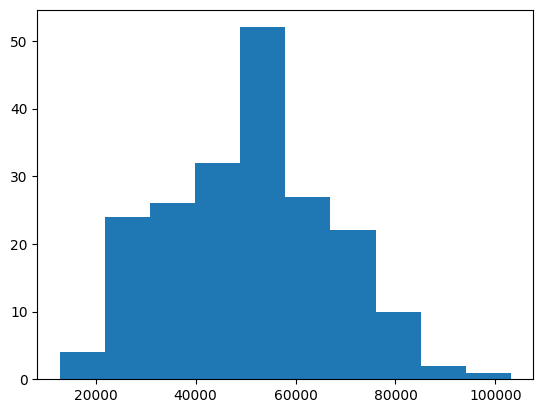

In [11]:
cloud_sizes = [len(d.batch) for d in dataset]

bins = plt.hist(cloud_sizes, bins=10)

In [12]:
bin_edges = bins[1]
bin_widths = np.diff(bin_edges)
probabilities = bins[0] * bin_widths

def sample_cloud_size(num_samples=1):
    samples = []
    bin_indices = np.random.choice(len(probabilities), size=num_samples, p=probabilities / np.sum(probabilities))
    for idx in bin_indices:
        # Step 3: Uniform sample within the bin
        left = bin_edges[idx]
        right = bin_edges[idx + 1]
        samples.append(int(np.random.uniform(left, right)))
    return samples if num_samples > 1 else samples[0]

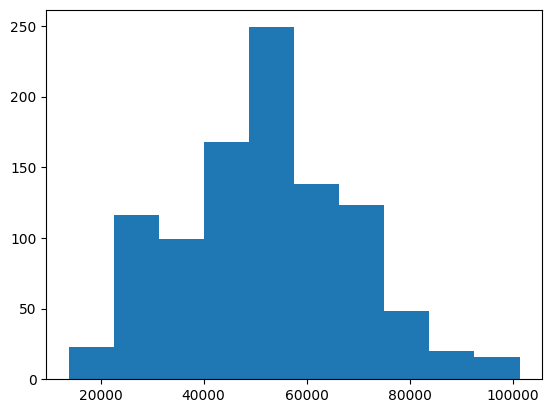

In [13]:
plt.hist(sample_cloud_size(num_samples=1000), bins=10)
plt.show()

In [14]:
@torch.no_grad()
def sample_point_cloud_with_features(model, num_points=100, timesteps=100):
    device = next(model.parameters()).device
    model.eval()

    # Diffusion schedule
    betas = linear_beta_schedule(timesteps).to(device)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    # Start from Gaussian noise (xyz + adc)
    x_t = torch.randn((num_points, 4), device=device)  # (N, 4) → [x, y, z, adc]
    batch = torch.zeros(num_points, dtype=torch.long, device=device)

    for t in reversed(range(timesteps)):
        t_tensor = torch.full((num_points,), t, dtype=torch.long, device=device)

        pos_t = x_t[:, :3]      # (N, 3)
        feature_t = x_t[:, 3:]  # (N, 1)

        pred_noise = model(pos=pos_t, x=feature_t, batch=batch, t=t_tensor)  # (N, 4)

        alpha = alphas[t]
        alpha_bar = alpha_bars[t]
        beta = betas[t]

        coef1 = 1 / torch.sqrt(alpha)
        coef2 = (1 - alpha) / torch.sqrt(1 - alpha_bar)
        x_0_est = coef1 * (x_t - coef2 * pred_noise)

        if t > 0:
            noise = torch.randn_like(x_t)
            sigma = torch.sqrt(beta)
            x_t = x_0_est + sigma * noise
        else:
            x_t = x_0_est

    # Split final result
    pos = x_t[:, :3]         # (N, 3)
    adc = x_t[:, 3:].squeeze(-1)  # (N,)

    return pos, adc


In [15]:
gen_data = []
for num_points in tqdm(sample_cloud_size(num_samples=10)):
    gen_data.append(sample_point_cloud_with_features(model, num_points=num_points, timesteps=10))

len(gen_data)

  0%|          | 0/10 [00:00<?, ?it/s]

10

In [16]:
all_gen_pos = []
all_gen_x = []
for pos, x in tqdm(gen_data):
    all_gen_pos.extend(pos.tolist())
    all_gen_x.extend(x.tolist())
all_gen_pos = np.array(all_gen_pos)
all_gen_x = np.array(all_gen_x).flatten()
all_gen_pos.shape, all_gen_x.shape

  0%|          | 0/10 [00:00<?, ?it/s]

((577767, 3), (577767,))

In [ ]:
all_pos = []
all_x = []
for data in tqdm(dataset):
    all_pos.extend(data.pos.tolist())
    all_x.extend(data.x.tolist())
all_pos = np.array(all_pos)
all_x = np.array(all_x).flatten()
all_pos.shape, all_x.shape

  0%|          | 0/200 [00:00<?, ?it/s]

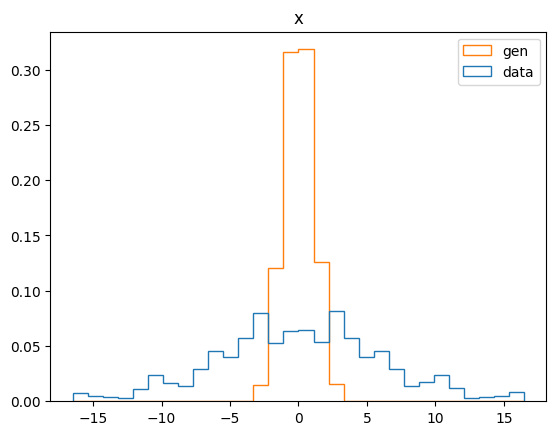

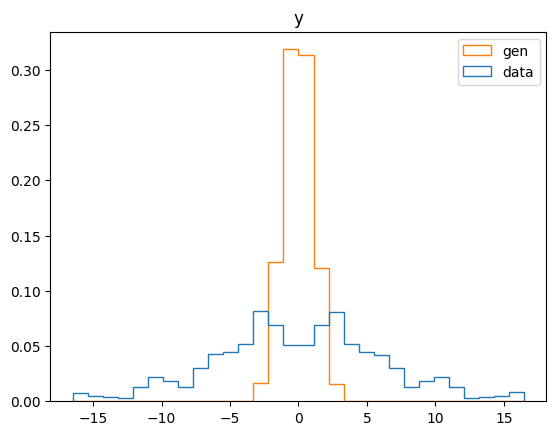

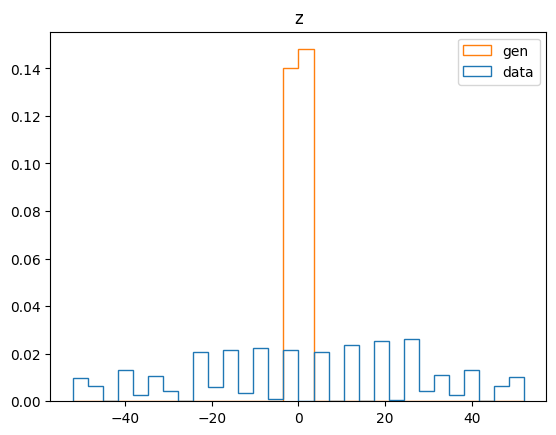

In [50]:
for i, label in enumerate(['x', 'y', 'z']):
    plt.hist([all_pos[:, i], all_gen_pos[:,i]], bins=30, label=["data", "gen"], density=True, histtype="step")
    plt.title(label)
    plt.legend()
    plt.show()

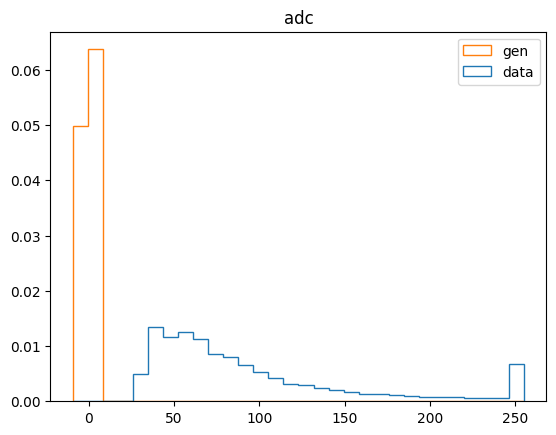

In [45]:
plt.hist([all_x, all_gen_x], bins=30, label=["data", "gen"], density=True, histtype="step")
plt.title("adc")
plt.legend()
plt.show()

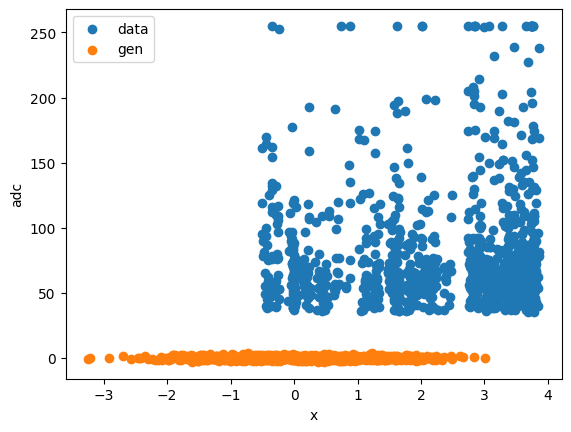

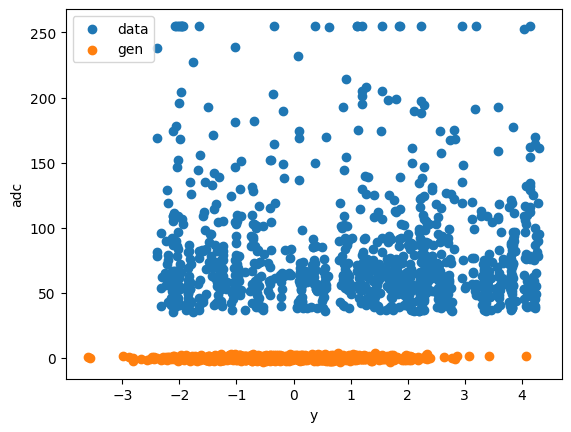

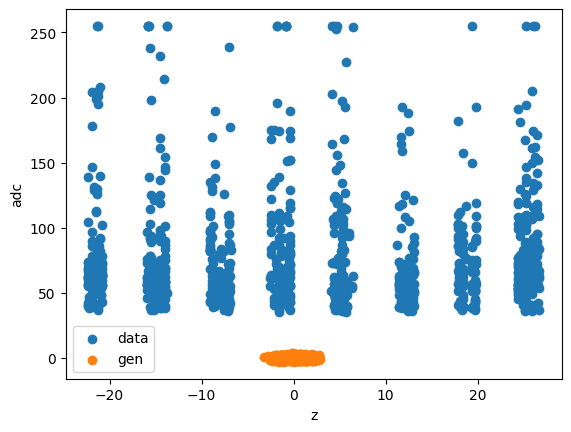

In [51]:
points_to_draw = 1000
for i, label in enumerate(['x', 'y', 'z']):
    plt.scatter(all_pos[:points_to_draw, i], all_x[:points_to_draw], label="data")
    plt.scatter(all_gen_pos[:points_to_draw, i], all_gen_x[:points_to_draw], label="gen")
    plt.xlabel(label)
    plt.ylabel('adc')
    plt.legend()
    plt.show()